In [453]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

Attached you'll find electricity data for **5/1/17 - 6/20/17 for five customers.** <p>There's one CSV per customer with 
15-minute interval data (NOTE: interval-ending, in kWh--NOT average kW). <p>A demand response dispatch occurred on **6/13/17, from 2PM - 6PM EDT.**  Assume there were no prior event days leading up to 6/13/17.

In [454]:
df = pd.read_csv('site_1.csv')

In [455]:
df.head()

,HE (EST),kWH
0,2017-05-01 00:00:00,1533.6
1,2017-05-01 00:15:00,1490.4
2,2017-05-01 00:30:00,1425.6
3,2017-05-01 00:45:00,1414.8
4,2017-05-01 01:00:00,1371.6


In [456]:
df.shape

(4896, 2)

In [457]:
df['HE (EST)'] = pd.to_datetime(df['HE (EST)'])

In [458]:
df.rename(columns={"HE (EST)": "time_est","kWH":"kwh"}, inplace=True)

In [459]:
df.head()

,time_est,kwh
0,2017-05-01 00:00:00,1533.6
1,2017-05-01 00:15:00,1490.4
2,2017-05-01 00:30:00,1425.6
3,2017-05-01 00:45:00,1414.8
4,2017-05-01 01:00:00,1371.6


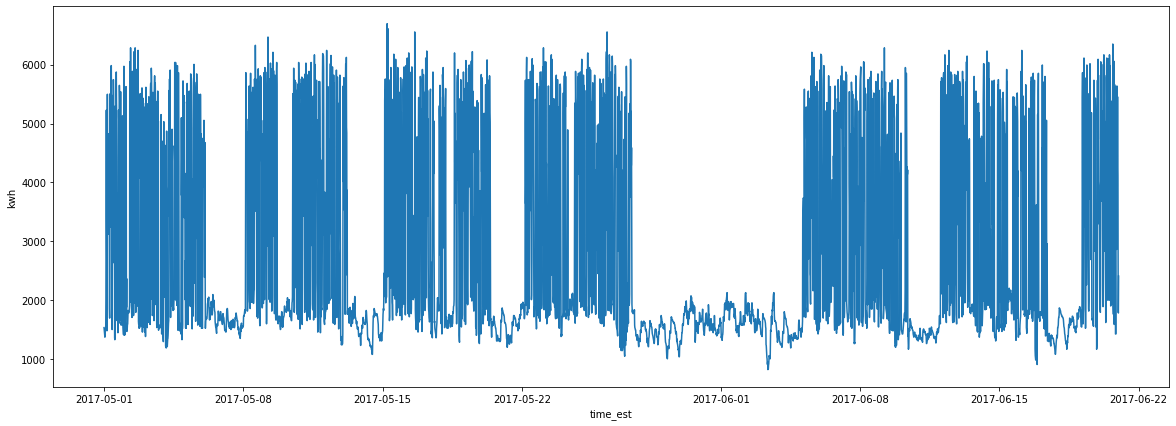

In [460]:
fig, ax = plt.subplots(figsize=(20,7))

sns.lineplot(x='time_est',y='kwh',data=df, ax=ax)
plt.show()

1) Calculate customer baselines (CBLs) for the event day and answer the questions below.  The CBL methodology can be found in section 5.2.2 of this NYISO manual, and assume we elected to use the Weather-Sensitive CBL option. 
<p>How did each customer perform, in kW? 
Was the weather adjustment calculation helpful or hurtful? Do you think it provided a more accurate assessment of customer performance during the dispatch vs. if we hadn't used the adjustment factor? 
Please take one example customer and show, graphically, how this customer performed on event day. (For example: a graph of baseline and event day load data.)  The goal of this request is to help the customer understand visually how they did (or didn't) perform.

### Calculating CBLs for event day
* Determine the resources peak hour within past 30 days during same daily hours as response event
* Multiple peak hour by 25% to calculate initial seed value
* No prior event days leading up to 6/13/17.

In [461]:
df.index = pd.DatetimeIndex(df.time_est, copy=False)
df.drop(columns='time_est', inplace=True)

In [462]:
test_df = df.copy()

Assign floor to each time reading to set up for hourly group by

In [463]:
test_df.index = test_df.index.floor('H')

In [464]:
test_df = test_df.groupby(test_df.index)['kwh'].sum().reset_index()

In [465]:
test_df.index = pd.DatetimeIndex(test_df.time_est, copy=False)
test_df.drop(columns='time_est', inplace=True)

In [466]:
test_df

,kwh
time_est,
2017-05-01 00:00:00,5864.4
2017-05-01 01:00:00,5810.4
2017-05-01 02:00:00,12258.0
2017-05-01 03:00:00,9666.0
2017-05-01 04:00:00,16783.2
...,...
2017-06-20 19:00:00,15930.0
2017-06-20 20:00:00,9709.2
2017-06-20 21:00:00,17960.4


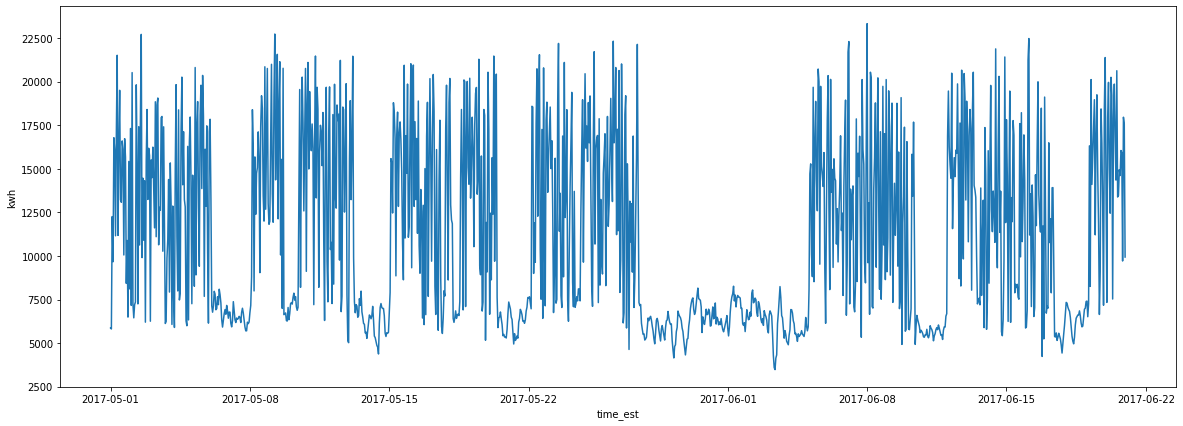

In [467]:
fig, ax = plt.subplots(figsize=(20,7))

sns.lineplot(x=test_df.index,y='kwh',data=test_df, ax=ax)
plt.show()

Demand response dispatch occurred from 14 - 18 EDT at 6/13/17

For later use, flag the hours that comprise the response event

In [117]:
# def peak_hour(dtindexed_df, start_hour, end_hour):
    
#     ## First, calculate the event date and the 30 day lookback
#     event_date = data[data.time_est == '2017-06-17']['time_est']
#     lookback = event_date - datetime.timedelta(30)
#     lookback.rename("times", inplace=True)
    
#     ## Next, filter down to the subset of data we're interested in
#     subset = data[(data.time_est > lookback) & (data.time_est < event_date)]
    
#     return subset

In [ ]:
test_df.iloc[1127]['time_est'] - datetime.timedelta(30)

In [468]:
# test_df['response'] = False

In [469]:
# test_df.loc['2017-06-13 14:00:00':'2017-06-13 18:00:00']['response'] = True

In [470]:
# test_df[test_df.response == True]

In [471]:
print(test_df.loc['2017-06-13'].index.day_name().unique())

Index(['Tuesday'], dtype='object', name='time_est')


Response event occured on a Tuesday, so it requires weekday CBL calculations

In [507]:
event_day = '2017-06-13'
event_day

'2017-06-13'

In [472]:
# Note to self: .loc slice is inclusive of both endpoints
subset_1 = test_df.loc['2017-05-01':'2017-06-13']

In [473]:
subset_1['hour'] = subset_1.index.hour

/Users/johnsylvester1/anaconda2/envs/newvenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [474]:
subset_2 = subset_1[subset_1.hour.isin([14,15,16,17,18])]

In [475]:
peak_hour = subset_2[subset_2.kwh==subset_2.kwh.max()]
seed_value = peak_hour.kwh * .25
print(seed_value)

time_est
2017-05-26 16:00:00    5254.2
Name: kwh, dtype: float64


In [476]:
seed_value[0]

5254.2

I.A.3: Creating: Average Daily Event Period Usage
<br>-- defined as the simple average of the
resource’s actual usage over the hours that define the event for which the
CBL is being developed. 

In [477]:
subset_3 = subset_2[subset_2.index.weekday.isin([0,1,2,3,4])]

In [478]:
subset_3.head()

,kwh,hour
time_est,,
2017-05-01 14:00:00,16599.6,14
2017-05-01 15:00:00,16124.4,15
2017-05-01 16:00:00,10054.8,16
2017-05-01 17:00:00,16729.2,17
2017-05-01 18:00:00,15670.8,18


Group by date, removing the hourly granularity

In [479]:
subset_4 = subset_3.groupby(subset_3.index.date)['kwh'].mean().reset_index()

In [480]:
subset_4.kwh.min()

6093.36

In [481]:
print(seed_value[0])

5254.2


**I.A.7.** <p>Rank the days from the CBL Window according to their Average Daily
Event Period Usage level, and eliminate the days with the lowest Average
Daily Event Period Usage, so that a maximum of **five** weekdays remain. 

In [482]:
subset_5 = subset_4.sort_values(by='kwh',ascending=False)[:5]

In [483]:
subset_5.index = pd.DatetimeIndex(subset_5['index'], copy=False)
subset_5.drop(columns='index', inplace=True)

**I.B.** Calculate hourly Average Day CBL values for the event.<p>
**I.B.1.** For each hour of the event, compute the CBL as the simple average of the
corresponding hourly Loads from the CBL Basis for Weekdays. 

Select down to just the top 5 days, and get data with hourly granularity

In [484]:
subset_6 = pd.DataFrame()

for date in subset_5.index.date:
    values = subset_3.loc[str(date)]
    subset_6 = pd.concat([subset_6,values])

In [485]:
subset_7 = subset_6.groupby(by='hour')['kwh'].mean()

In [486]:
subset_7

hour
14    17921.52
15    16541.28
16    17200.08
17    12124.08
18    16232.40
Name: kwh, dtype: float64

**III.B.1.** <p>Calculate the Adjustment Basis Average CBL 

In [490]:
## Adjustment period: 4 hours before event to 2 hours before
## Calculate the Average day CBL using the adjustment period, relying on original 5 days
subset_5

,kwh
index,
2017-05-08,16798.32
2017-05-10,16711.92
2017-06-05,15796.08
2017-05-04,15504.48
2017-05-05,15208.56


In [497]:
subset_8 = pd.DataFrame()

for date in subset_5.index.date:
    values = subset_1.loc[str(date)]
    subset_8 = pd.concat([subset_8,values])

In [501]:
subset_8

,kwh,hour
time_est,,
2017-05-08 00:00:00,6750.0,0
2017-05-08 01:00:00,7160.4,1
2017-05-08 02:00:00,8802.0,2
2017-05-08 03:00:00,18392.4,3
2017-05-08 04:00:00,16470.0,4
...,...,...
2017-05-05 19:00:00,12852.0,19
2017-05-05 20:00:00,17463.6,20
2017-05-05 21:00:00,10303.2,21


In [502]:
adjusted_hours = [10,11]

subset_9 = subset_8[subset_8.hour.isin(adjusted_hours)]

In [525]:
adjust_basis_avg_cbl = subset_9.groupby(by='hour')['kwh'].mean().mean()

**III.B.2.a** <p>The Adjustment Basis Average Load is the simple average of
the resource’s Load over the two-hour adjustment period on
the event day. 

In [514]:
subset_10 = test_df.loc[event_day][test_df.loc[event_day].index.hour.isin(adjusted_hours)]

In [521]:
adjust_basis_avg_load = subset_10['kwh'].mean()

**III.B.3.a** <p>The Gross Adjustment Factor is equal to the Adjustment
Basis Average Load divided by the Adjustment Basis
Average CBL

In [526]:
gross_adjust_factor = adjust_basis_avg_load / adjust_basis_avg_cbl
gross_adjust_factor

1.0061634515328584

**III.B.4.** Determine the Final Adjustment Factor. The Final Adjustment Factor is as
follows:
* If the Gross Adjustment Factor is greater than 1.00, then the
Final Adjustment Factor is the lesser of the Gross
Adjustment Factor or 1.20

In [530]:
if gross_adjust_factor > 1.00:
    final_adjust_factor = min(gross_adjust_factor, 1.20)

**III.C.** Calculate the Adjusted CBL values. 
* The Event Adjusted CBL value for each hour of an event is the product of
the Final Adjustment Factor and the Average CBL value for that hour.

In [542]:
adjusted_cbl_values = final_adjust_factor * subset_7

In [548]:
adjusted_cbl_values = adjusted_cbl_values.reset_index()

In [550]:
adjusted_cbl_values

,hour,kwh
0,14,18031.978420
1,15,16643.231378
2,16,17306.091859
3,17,12198.806179
4,18,16332.447611


In [562]:
load_redux = adjusted_cbl_values['kwh'] - subset_1.loc['2017-06-13 14:00:00':'2017-06-13 18:00:00']['kwh'].values

In [563]:
load_redux

0    10590.778420
1     9072.431378
2    10113.291859
3    -1700.793821
4     8599.647611
Name: kwh, dtype: float64